In [1]:
using DifferentialEquations
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = -δ*y + γ*x*y
end
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

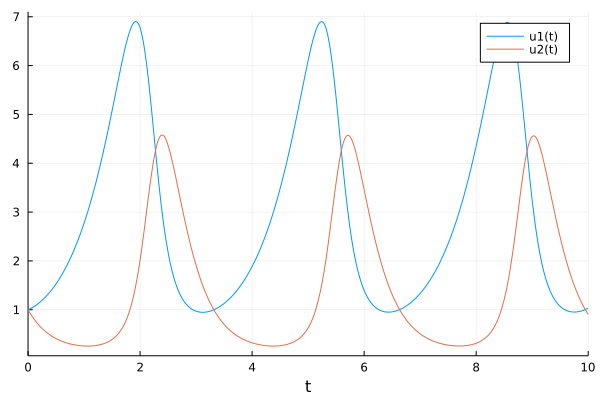

In [3]:
sol = solve(prob)
using Plots
plot(sol)

In [4]:
u0_f(p,t0) = [p[2],p[4]]
tspan_f(p) = (0.0,10*p[4])
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0_f,tspan_f,p)

ODEProblem with uType typeof(u0_f) and tType Unknown. In-place: true
timespan: tspan_f (generic function with 1 method)
u0: u0_f (generic function with 1 method)

In [5]:
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0,tspan,p)
sol = solve(prob,Tsit5(),saveat=0.1)
A = sol[1,:] # length 101 vector

101-element Vector{Float64}:
 1.0
 1.061078067335645
 1.14402767172576
 1.2491712125724486
 1.3776445705636395
 1.531230817748045
 1.71226975581856
 1.9235782758302449
 2.16839108970141
 2.450250667139229
 2.7728223025910044
 3.1397329894682455
 3.5539013554695407
 ⋮
 4.3461712649661255
 3.246586322134187
 2.3956662167528378
 1.8172822873986147
 1.442761279712482
 1.208908098691348
 1.0685925962278384
 0.9910229662215777
 0.9574213545847949
 0.9569793998644349
 0.983560917587679
 1.0337581393337103

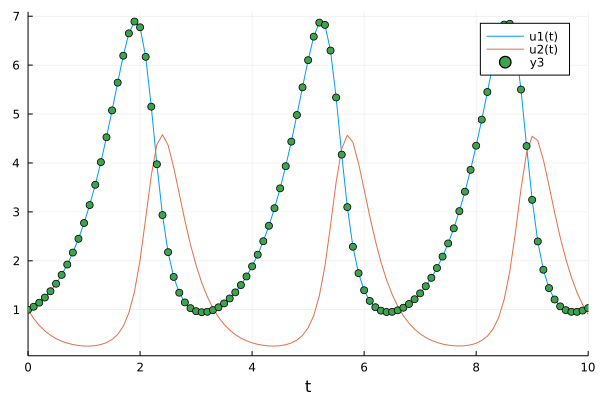

In [6]:
plot(sol)
t = 0:0.1:10.0
scatter!(t,A)

In [11]:
using Flux, DiffEqFlux
p = [2.2, 1.0, 2.0, 0.4] # Initial Parameter Vector
params = Flux.params(p)

function predict_rd() # Our 1-layer "neural network"
  solve(prob,Tsit5(),p=p,saveat=0.1)[1,:] # override with new parameters
end

loss_rd() = sum(abs2,x-1 for x in predict_rd()) # loss function

loss_rd (generic function with 1 method)

4311.399889162728

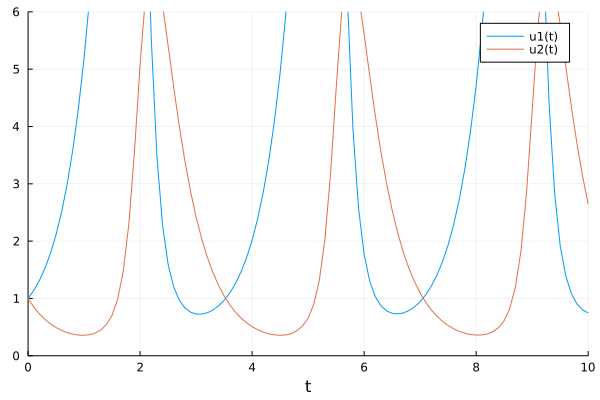

1972.5018536777677

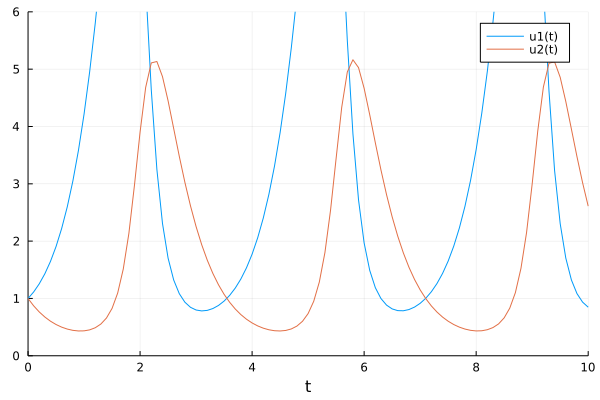

1016.9518450206517

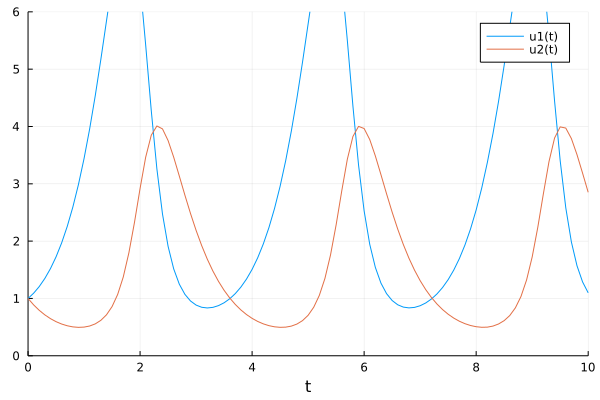

567.2154871765996

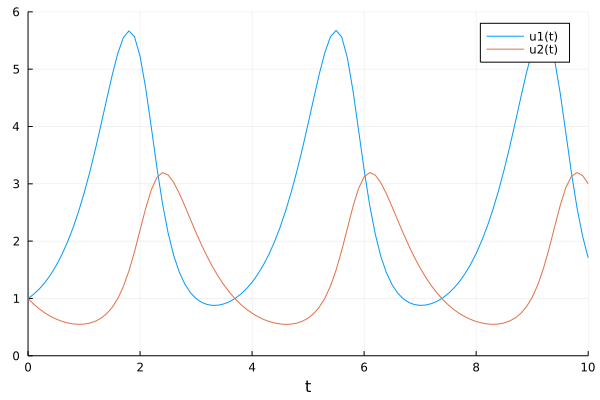

327.7021708991577

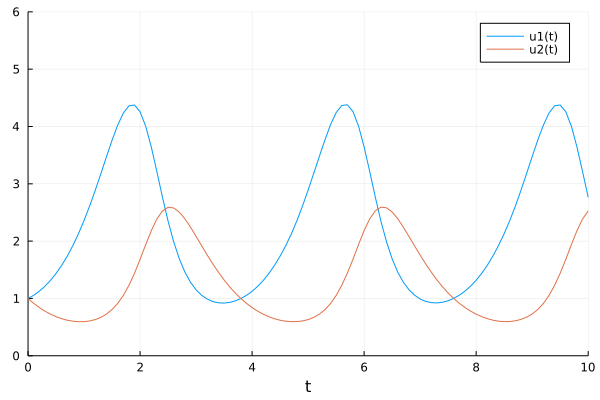

181.86729064877025

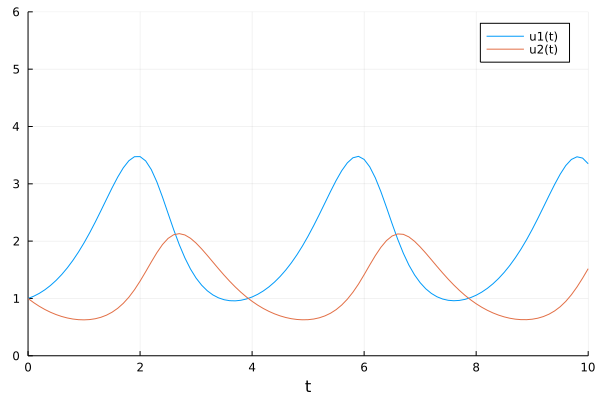

94.76343875045849

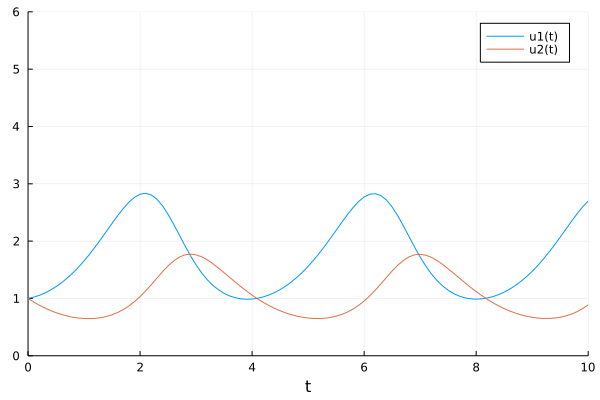

51.209934057868246

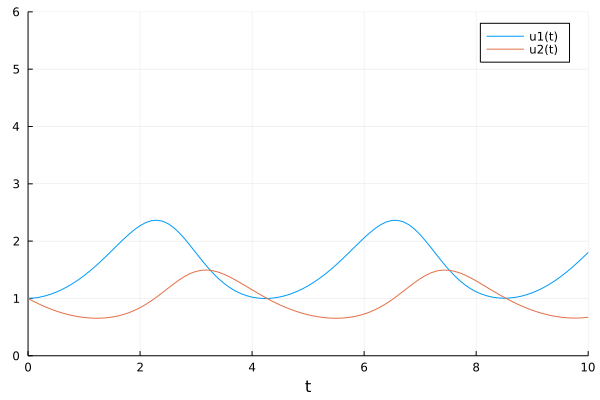

30.436508880703542

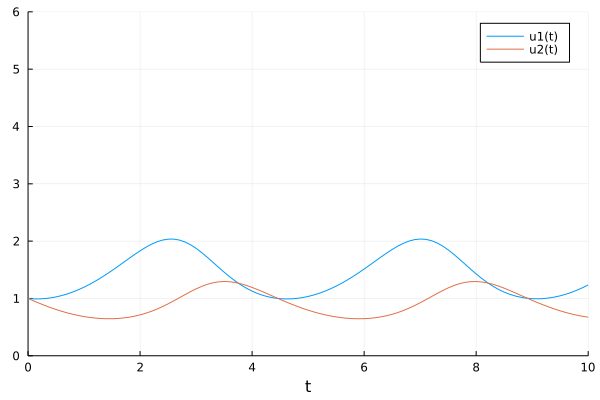

19.45884673909631

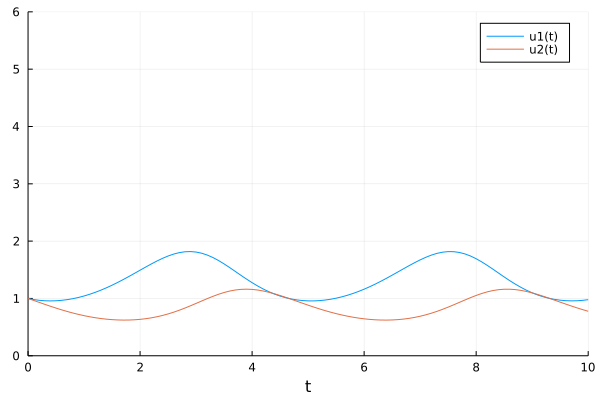

13.371471937407994

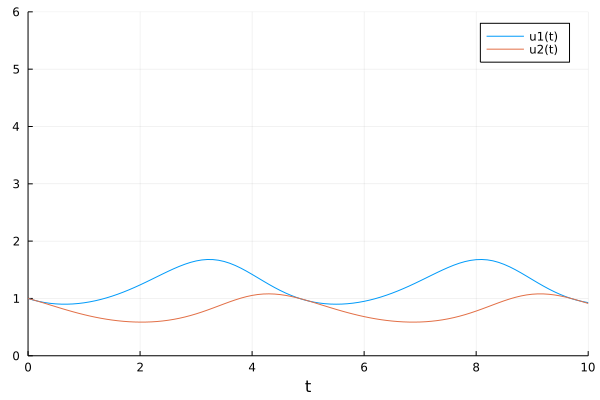

10.256823586308393

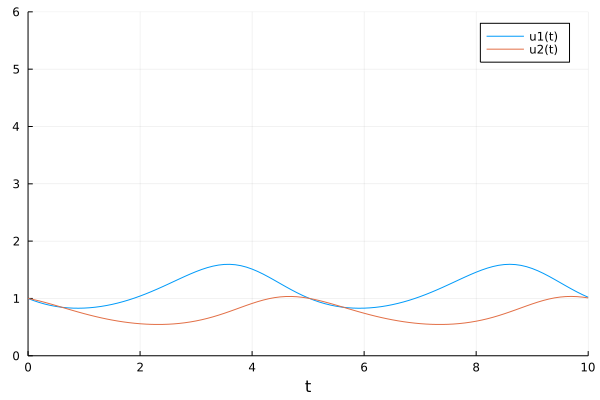

8.965652722405547

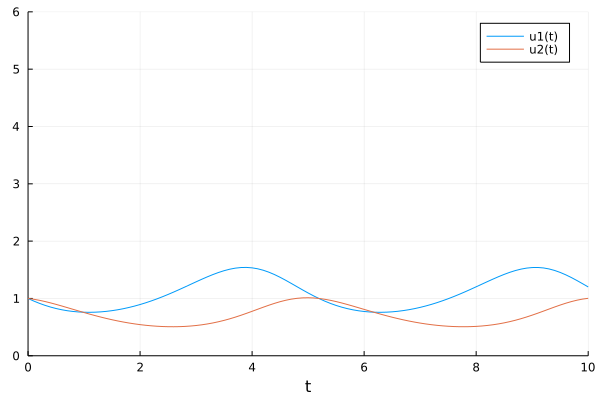

8.617918322447784

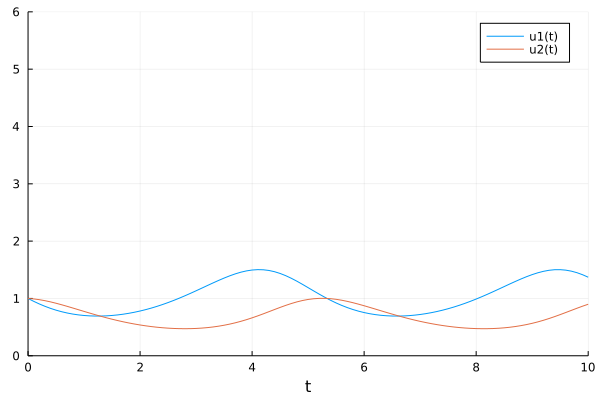

8.736299895154932

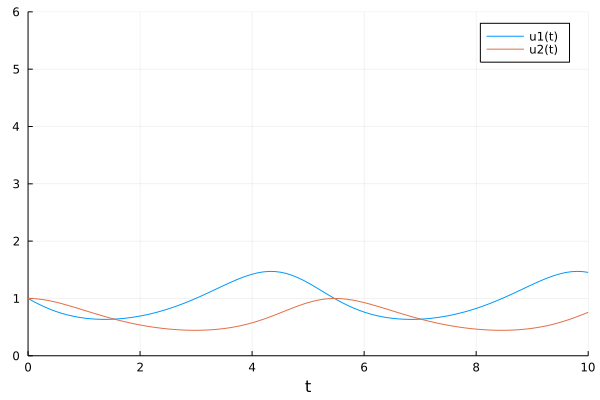

9.252418102121378

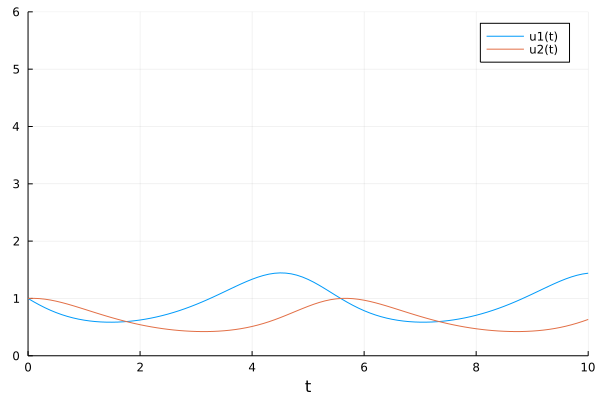

10.166946357882946

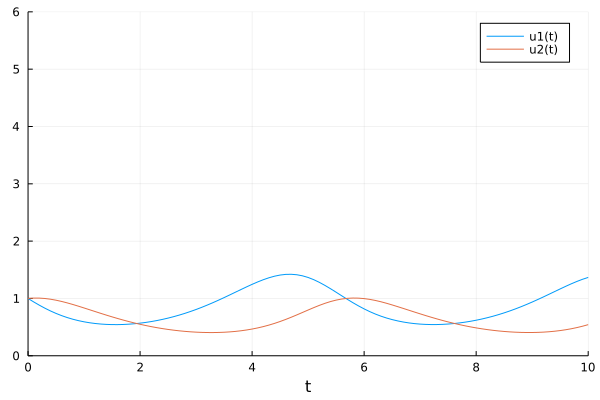

11.37141786387564

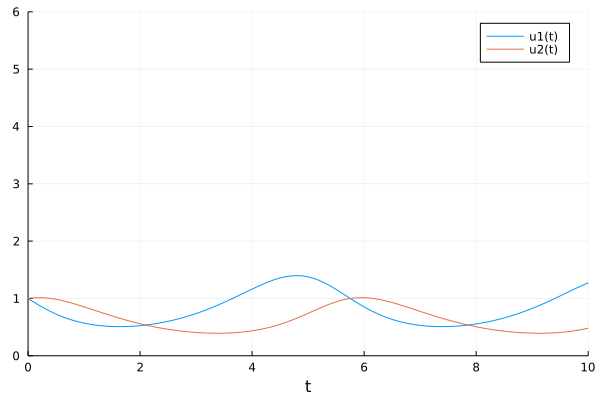

12.642605078174292

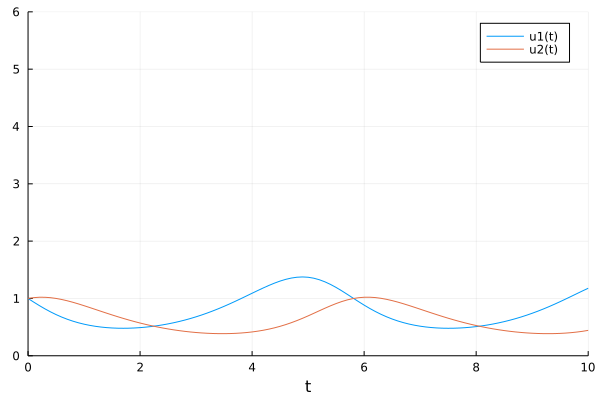

13.833440099833442

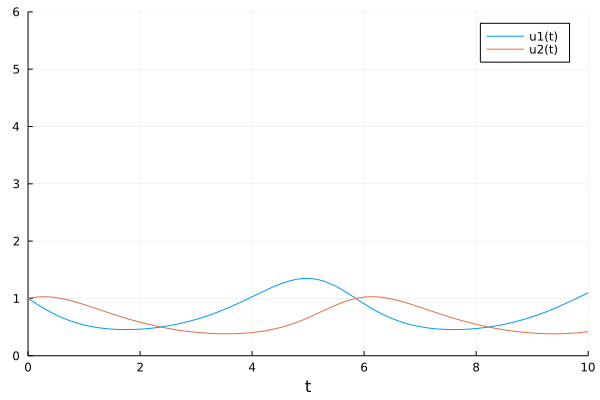

14.845115943862366

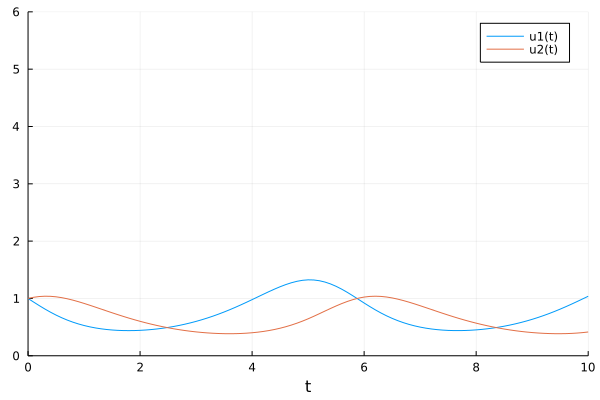

15.6516880059274

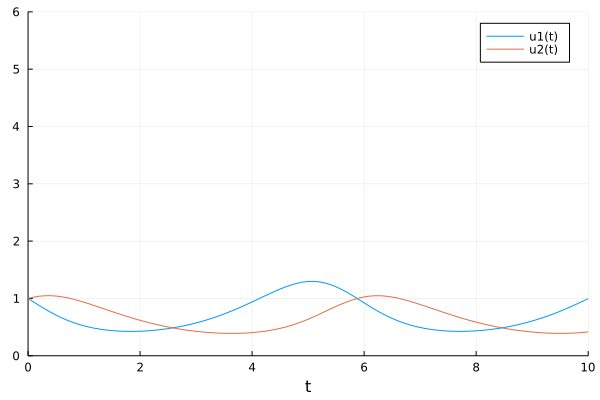

16.259121443088315

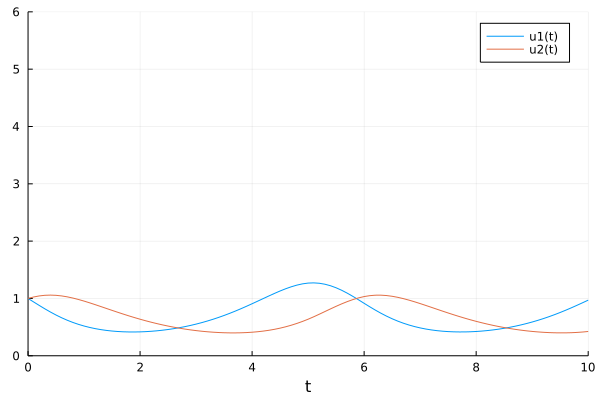

16.674925880200714

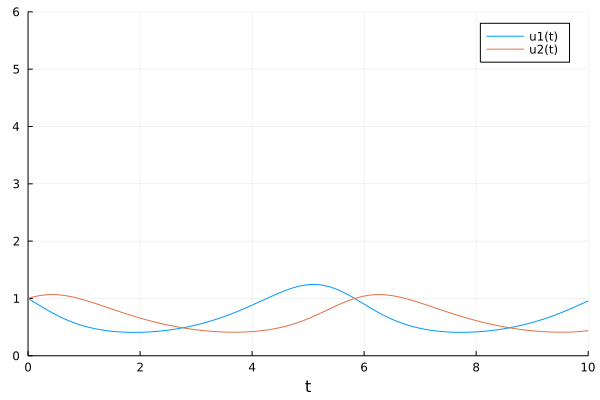

16.923714193712627

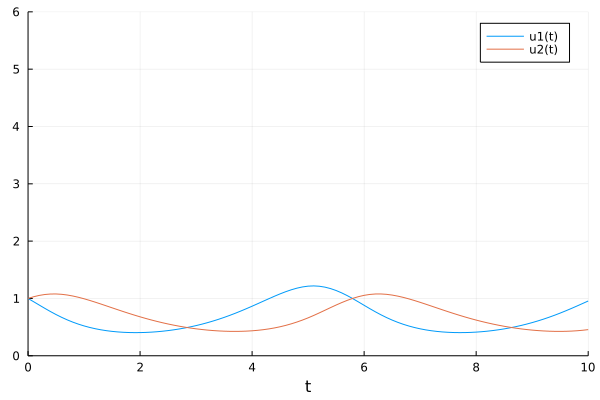

17.019321322592717

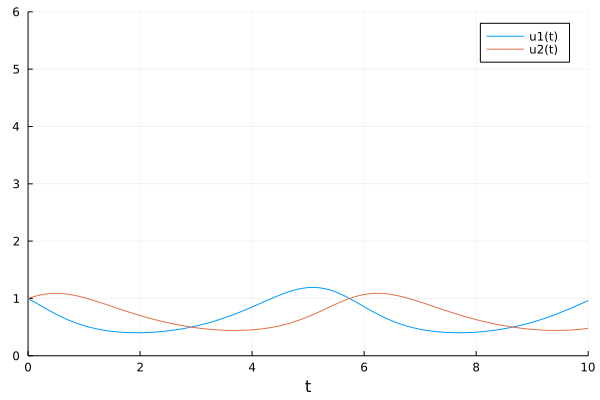

16.983020001971656

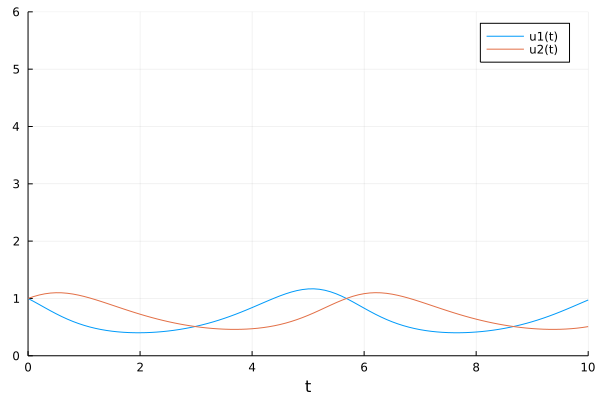

16.843597026447558

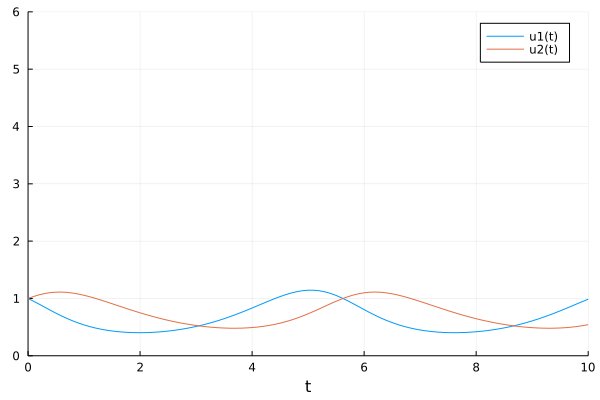

16.624465371434216

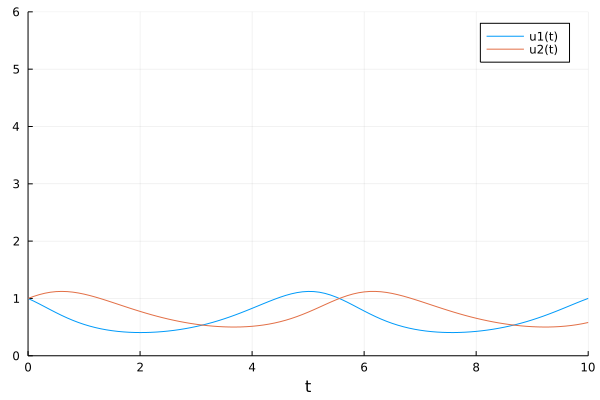

16.34695021114029

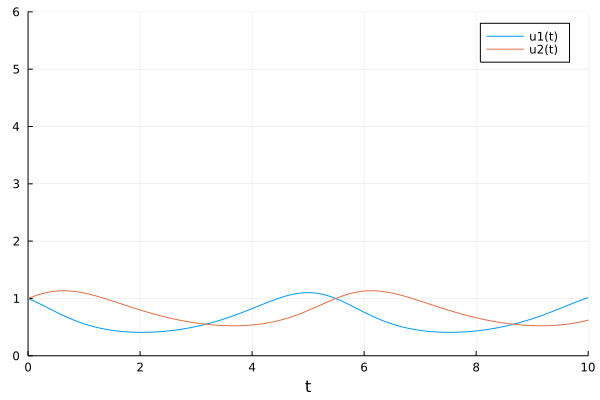

16.025654068586125

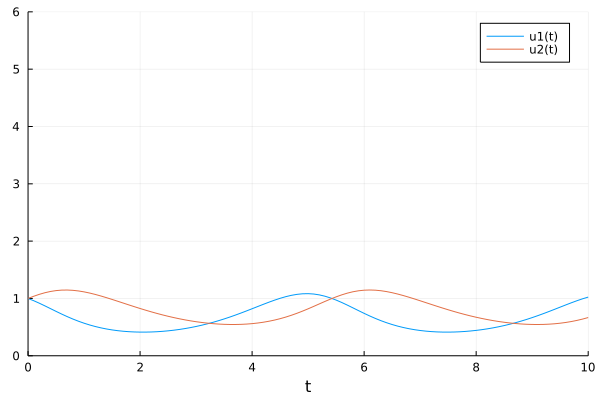

15.670524612936672

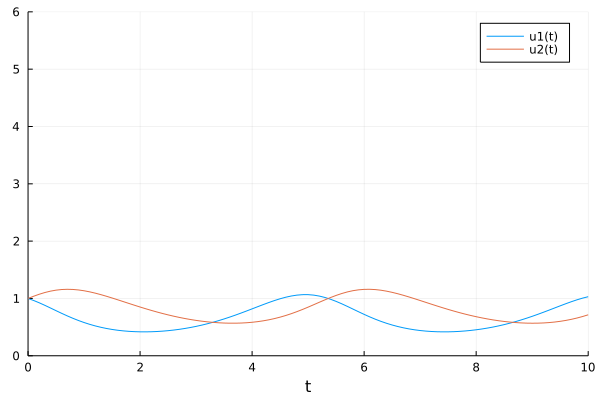

15.282923412658379

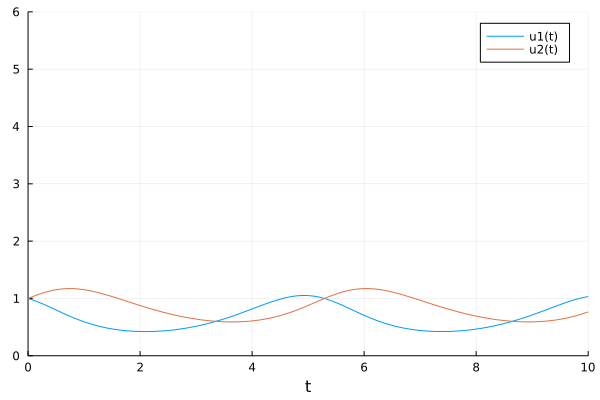

14.90902420465547

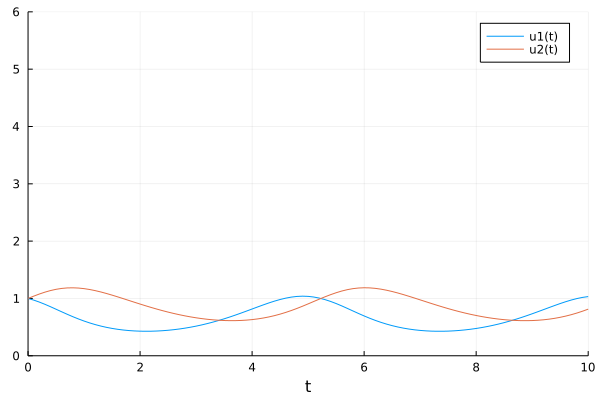

14.516521839268373

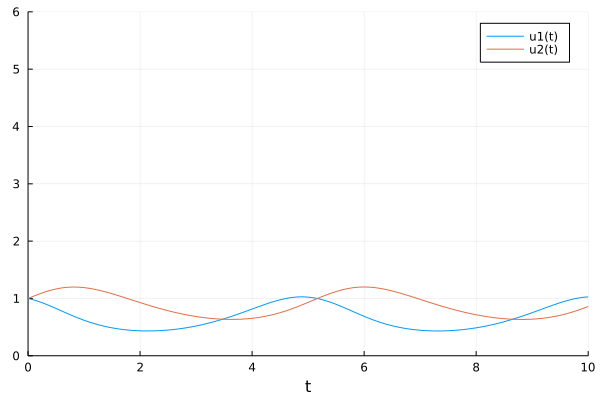

14.115911416959152

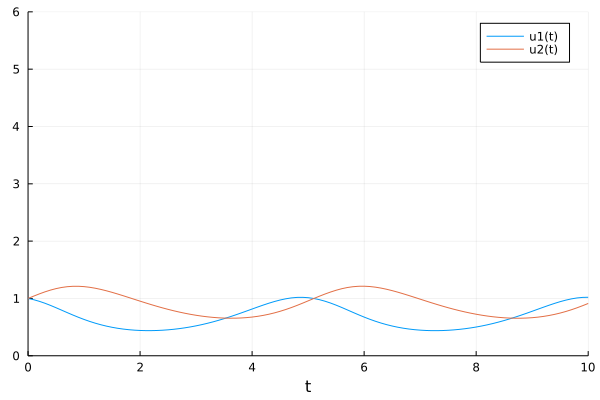

13.719104687030713

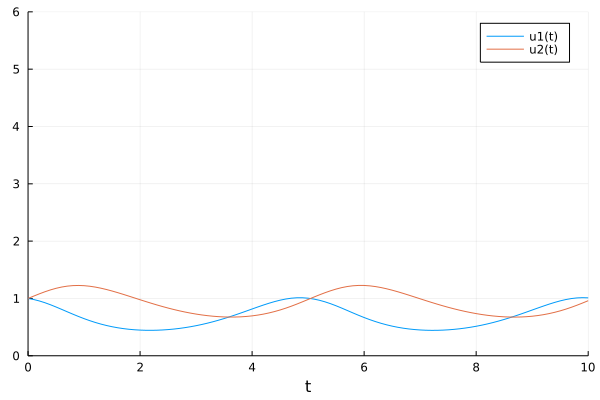

13.32715191206644

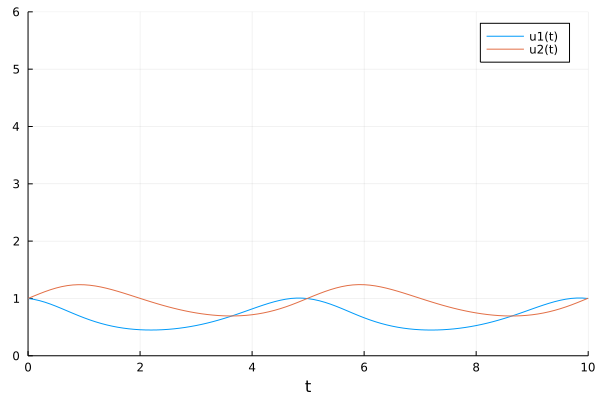

12.938548801737287

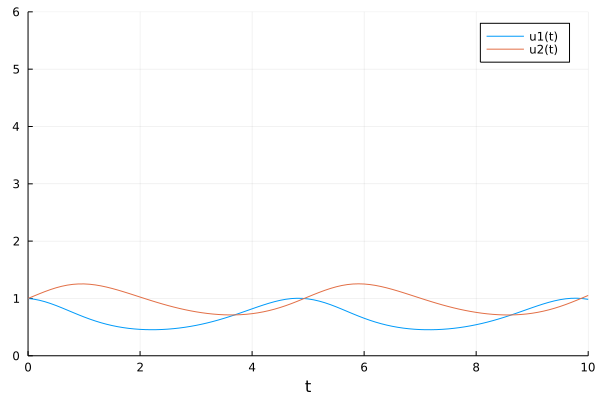

12.554514060032368

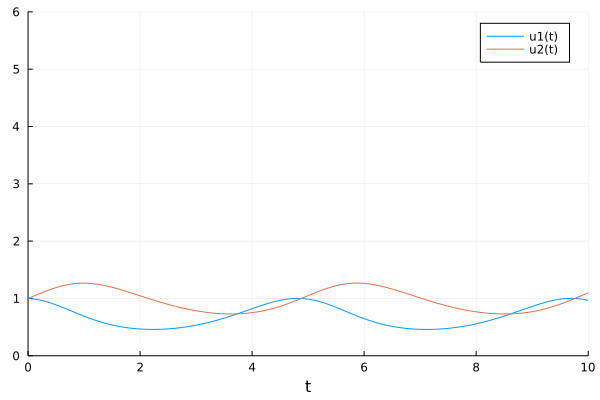

12.178574438345166

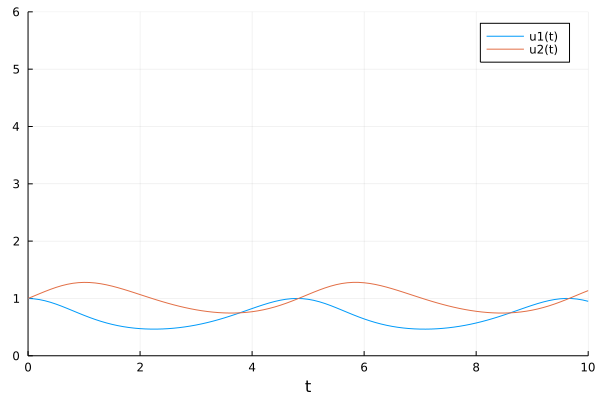

11.811527841993952

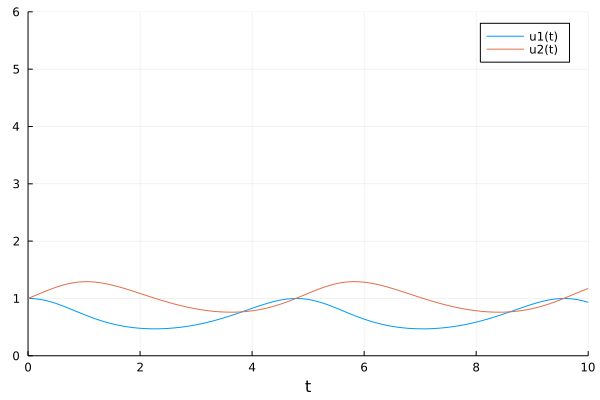

11.452934025714686

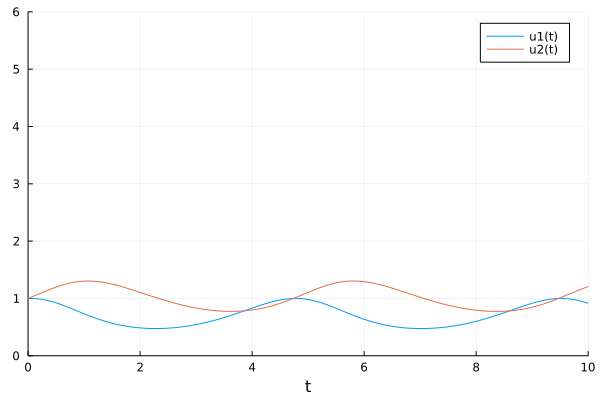

11.102298452501369

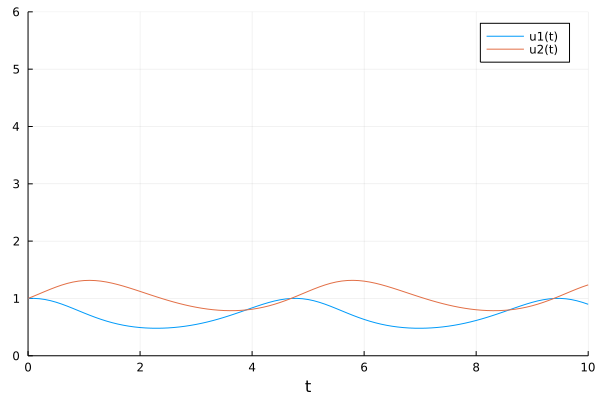

10.759126747371353

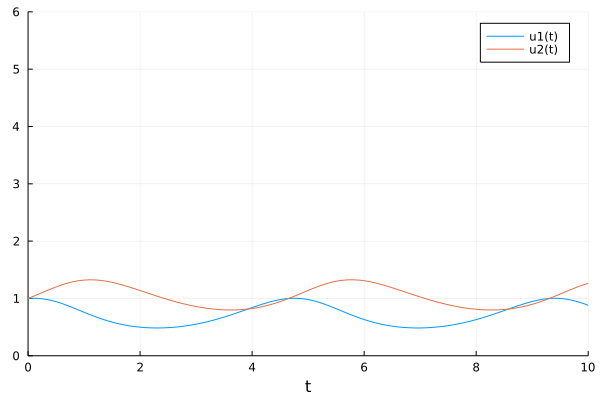

10.422890194276471

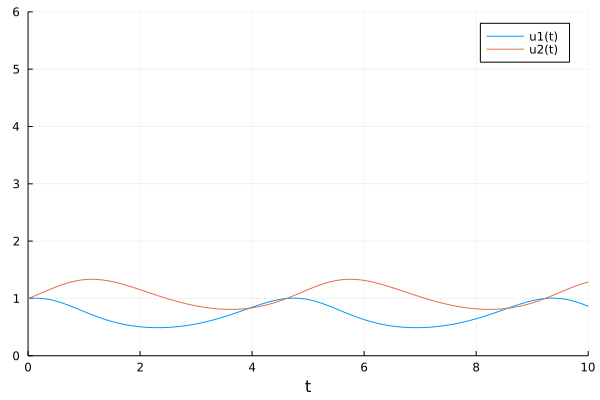

10.093024422975194

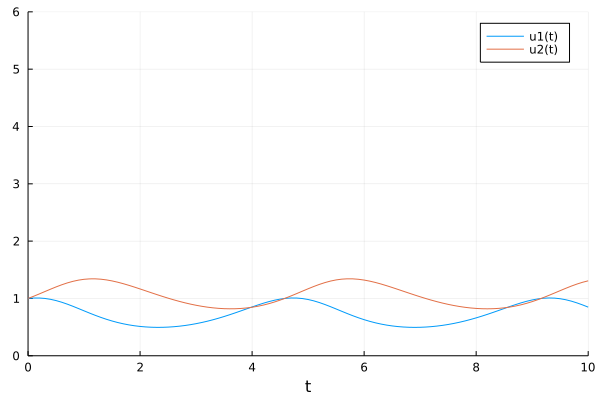

9.768934573971523

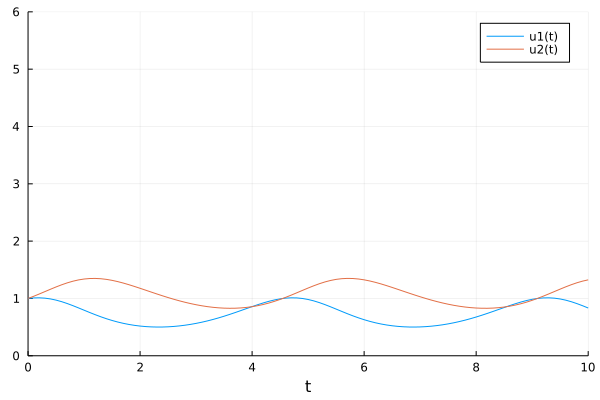

9.450012583748903

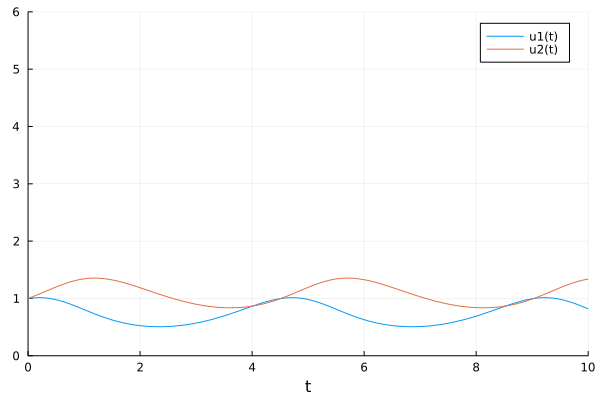

9.135655511873455

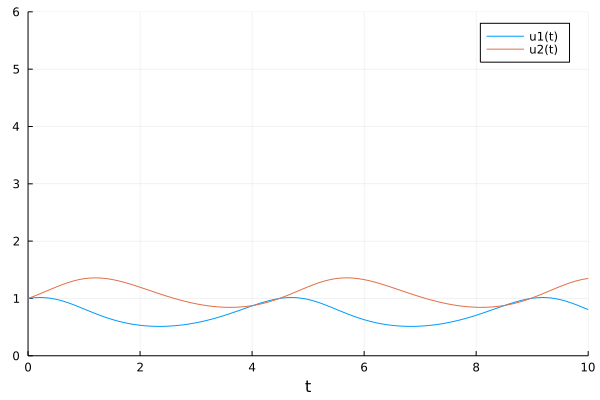

8.825289793670663

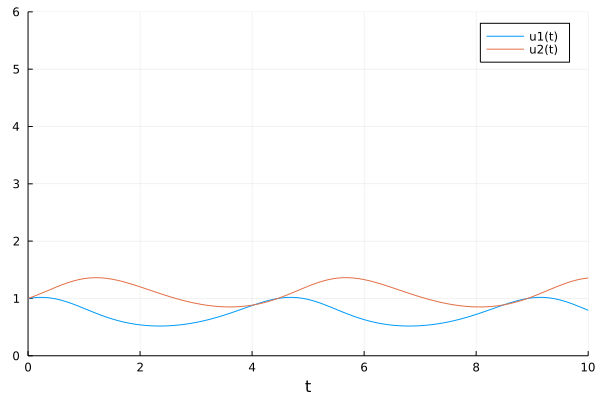

8.518387984600176

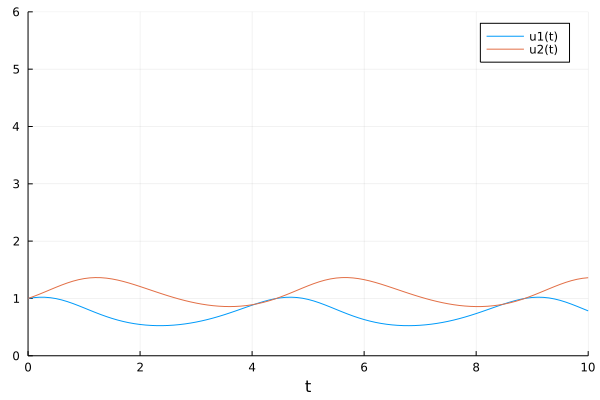

8.214478429805002

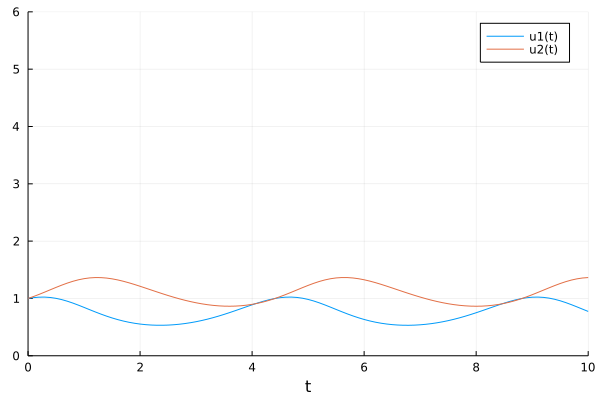

7.9131538333282725

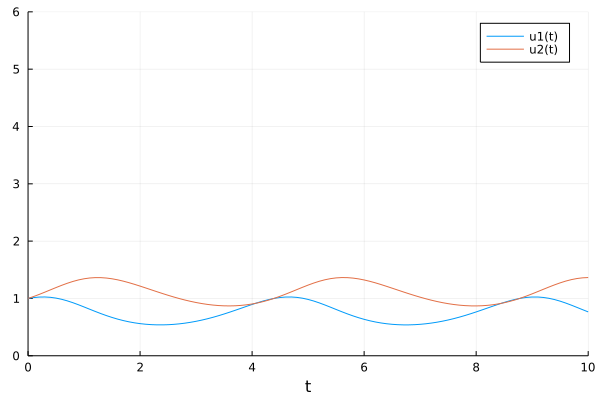

7.614071202093091

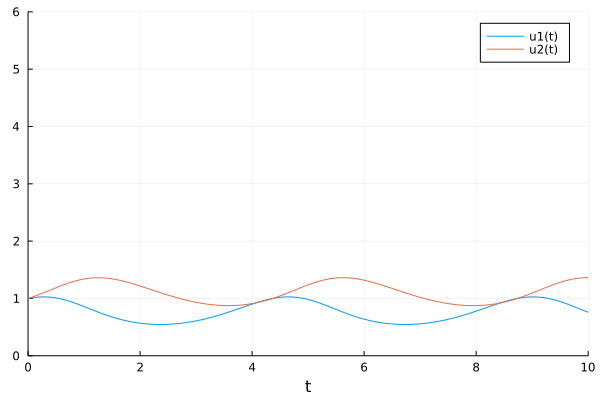

7.316932572295091

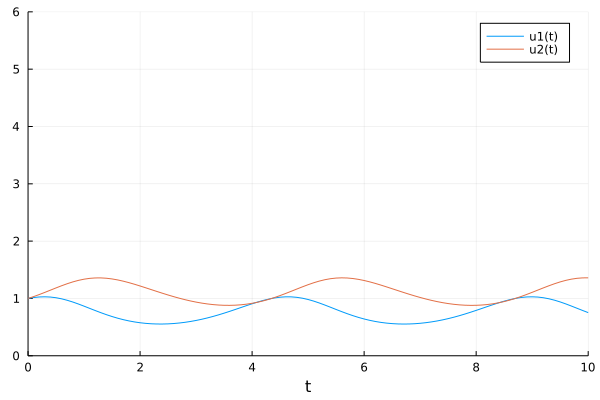

7.021419501850149

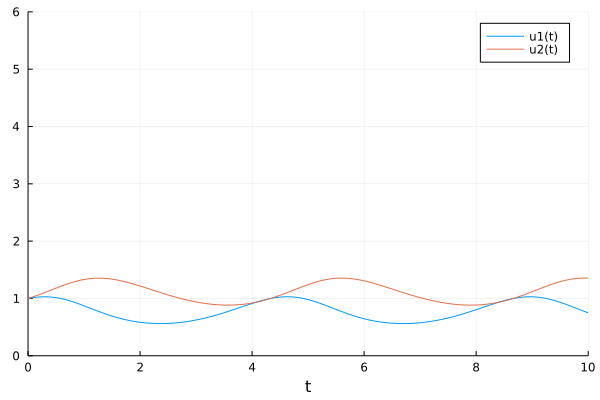

6.7271125517893875

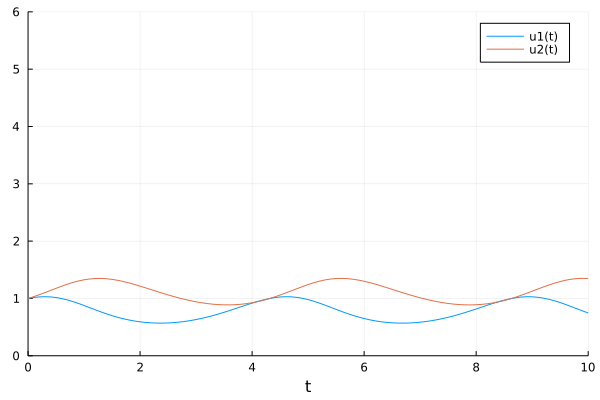

6.443148114399239

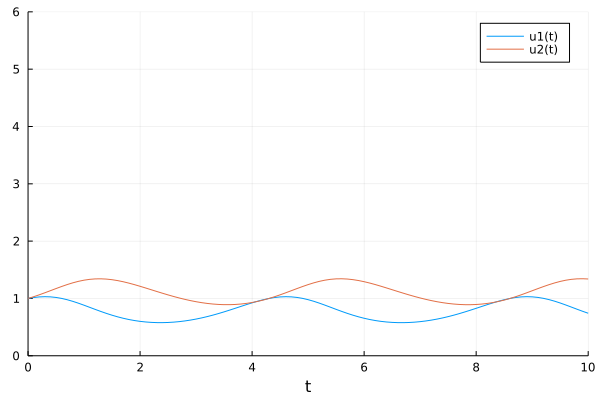

6.157963796341066

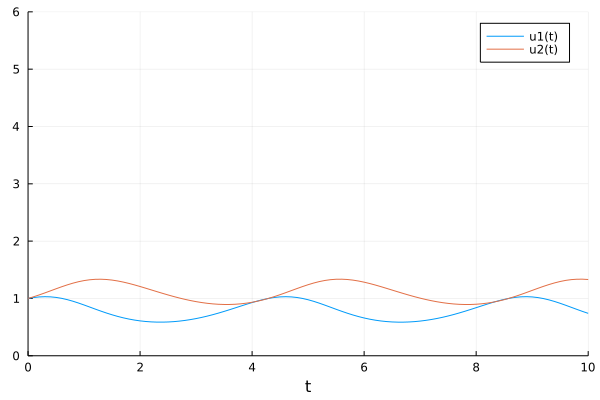

5.873690626864813

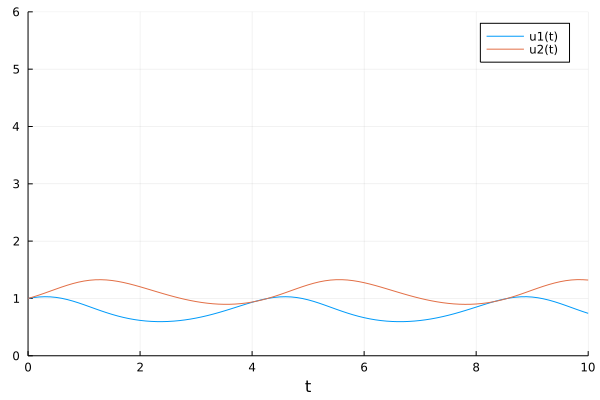

5.598006342800021

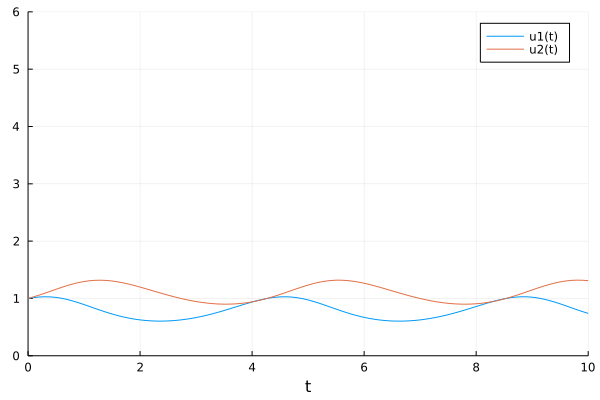

5.325558726903772

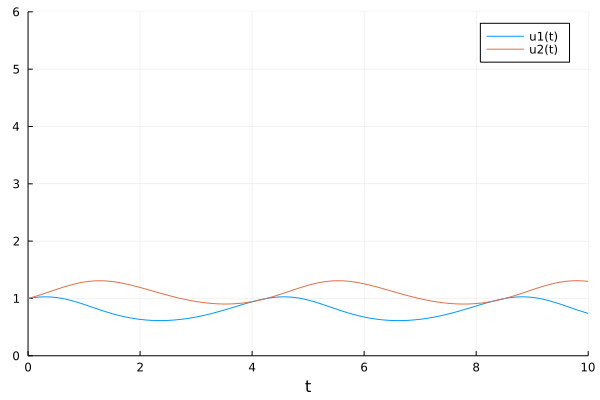

5.057680856954405

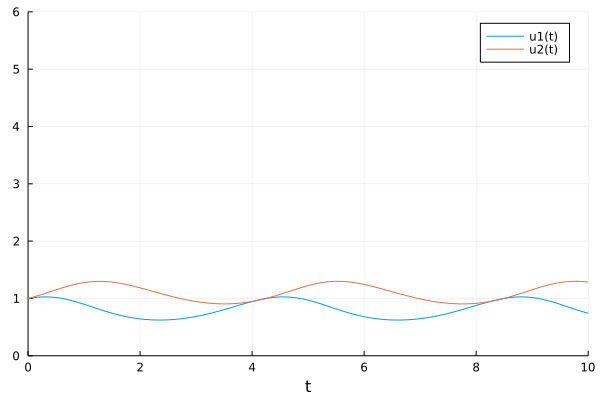

4.795341164188136

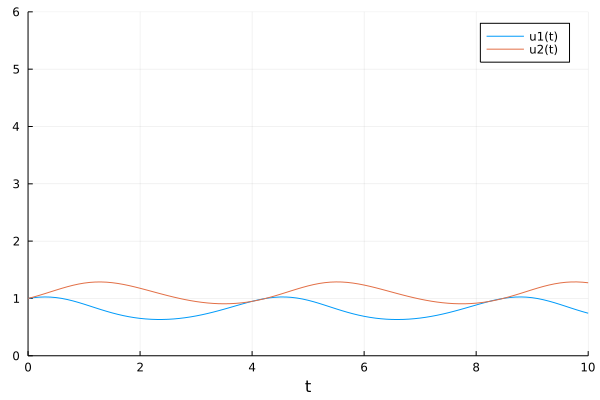

4.539232272955366

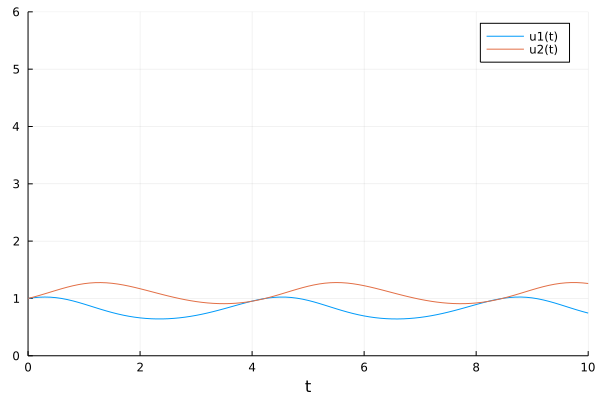

4.2899149751012144

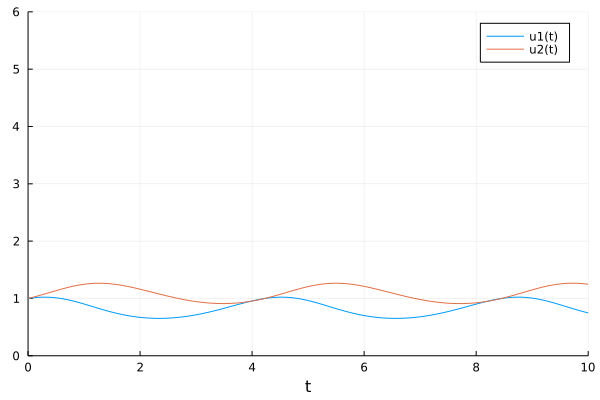

4.047843473221786

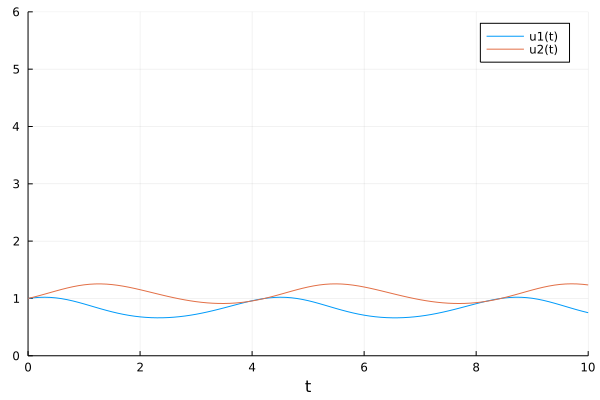

3.813395351272476

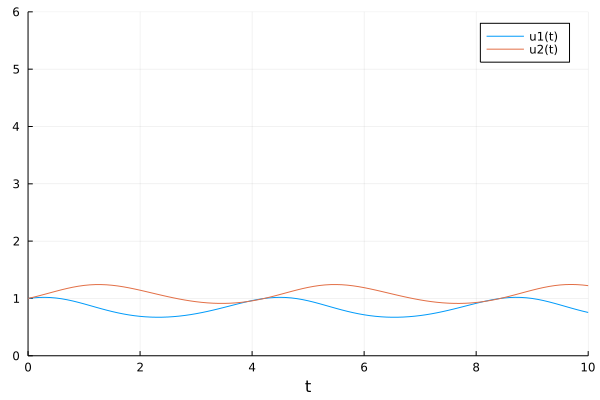

3.5868545844904767

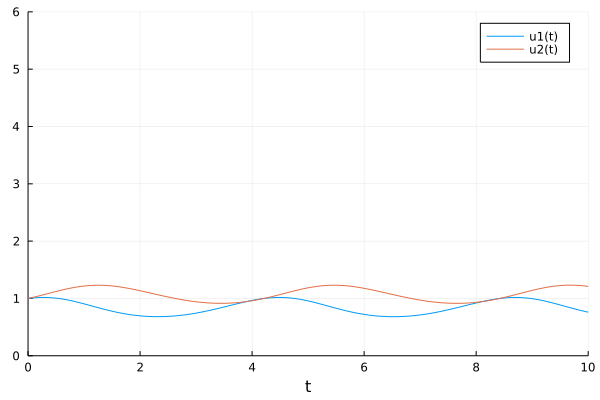

3.3699414858574617

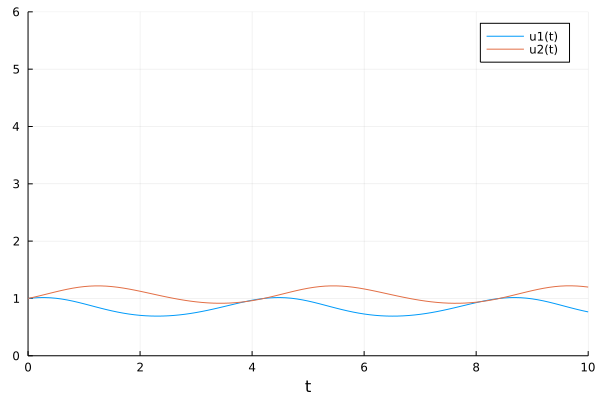

3.1636394691886567

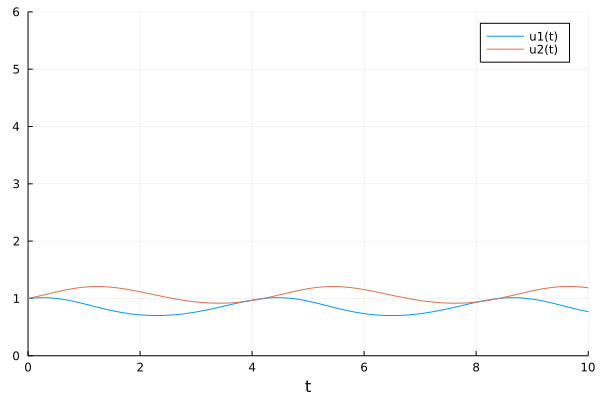

2.9669200133777713

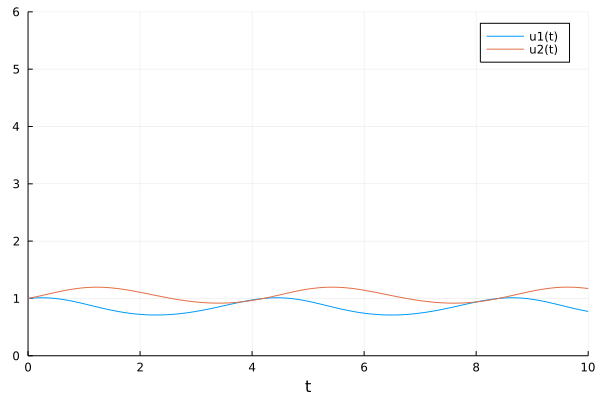

2.7792057600957207

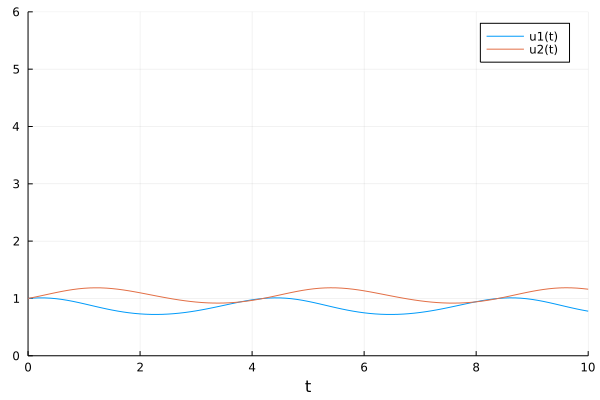

2.6005669877050885

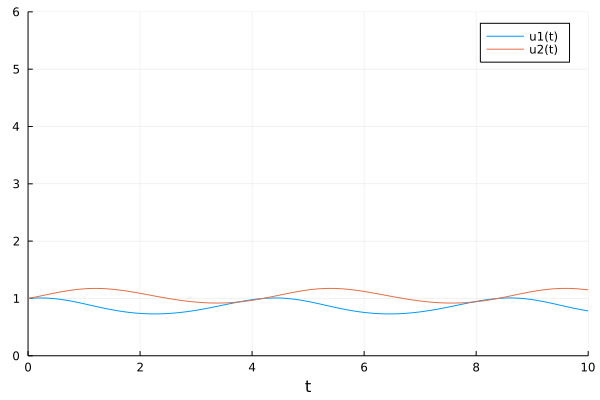

2.4308586002229378

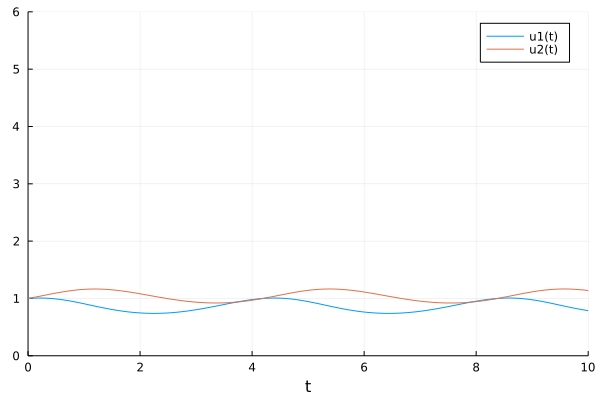

2.269849312314699

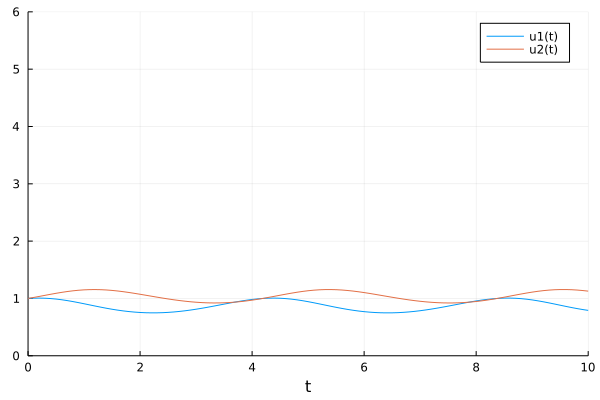

2.1173063980596103

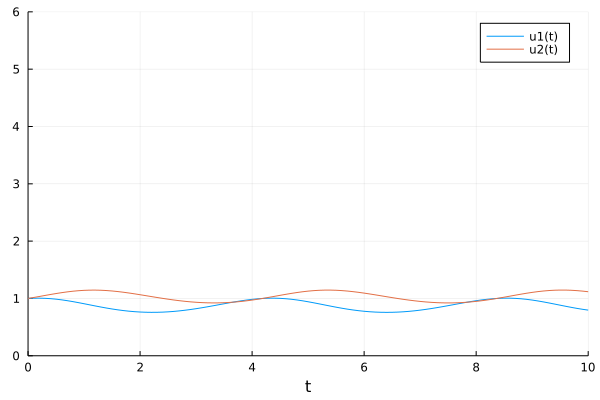

1.9730499973929567

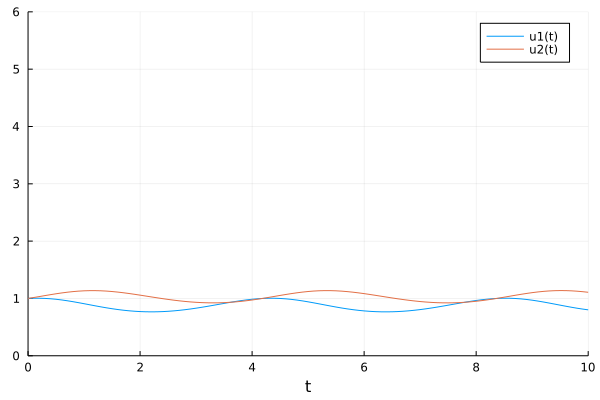

1.8369224134250457

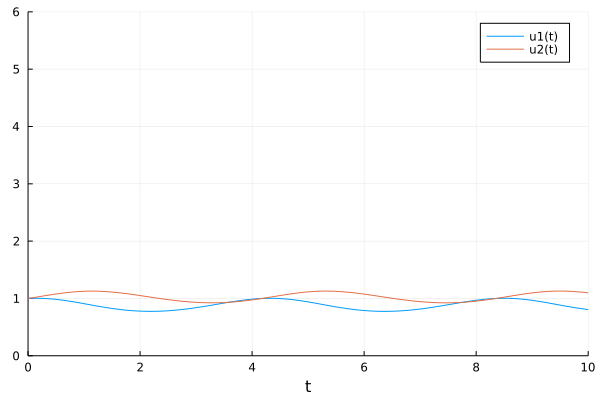

1.7087764306923336

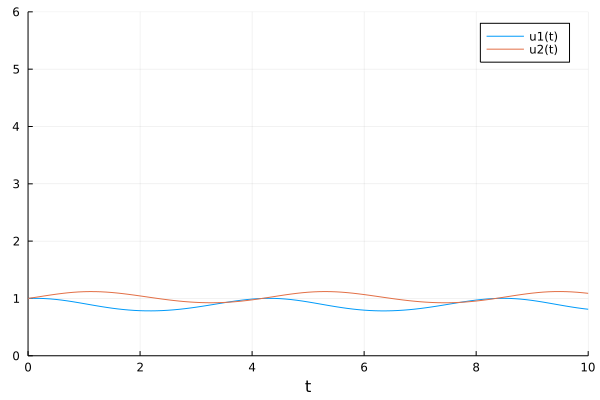

1.588522901632168

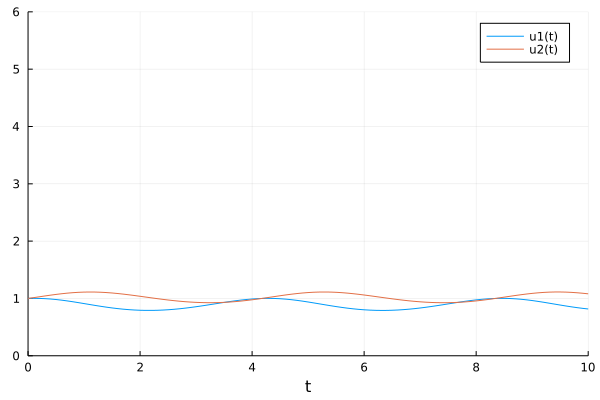

1.4755153543540838

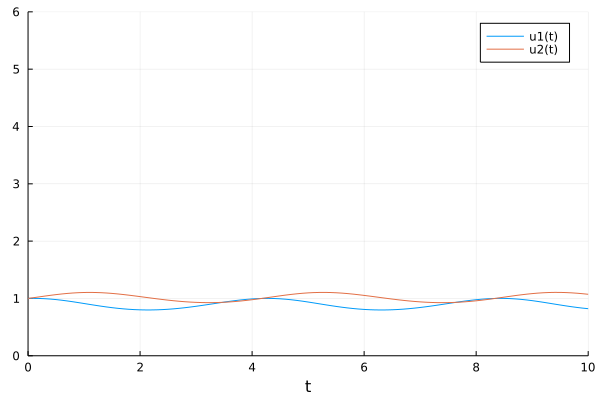

1.3690161187048662

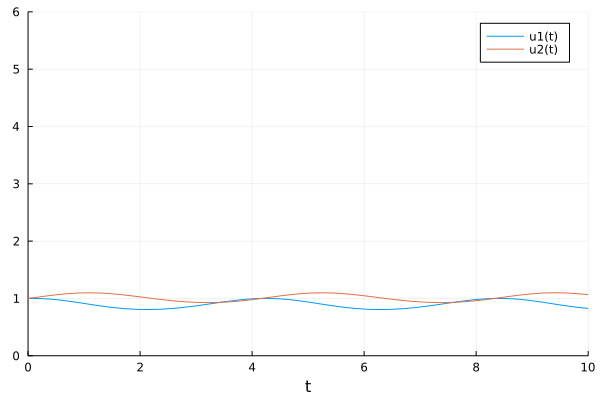

1.2684910991029528

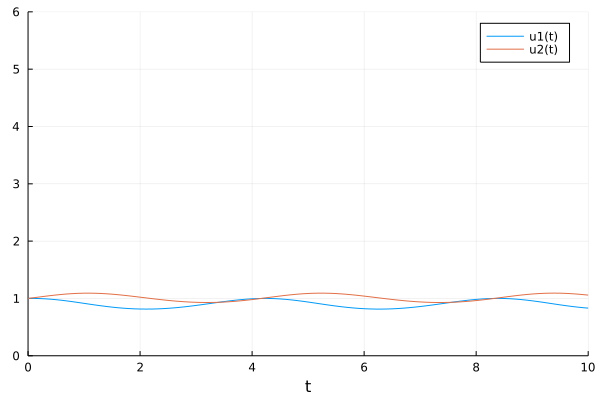

1.1736026135523265

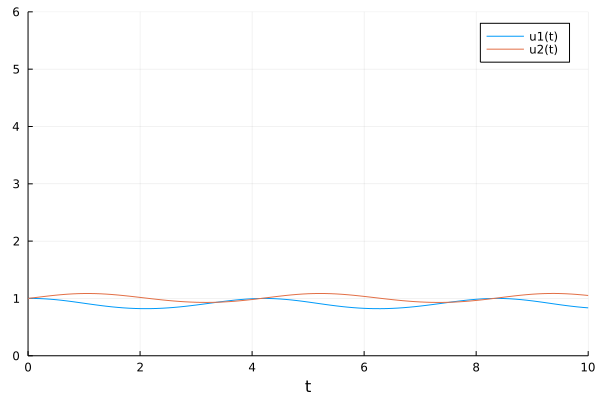

1.0841140929575124

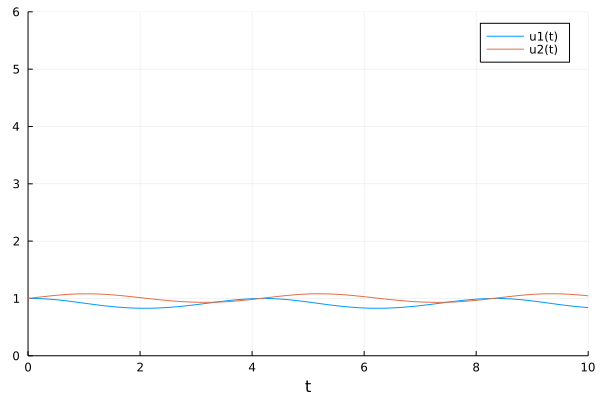

0.99980719247783

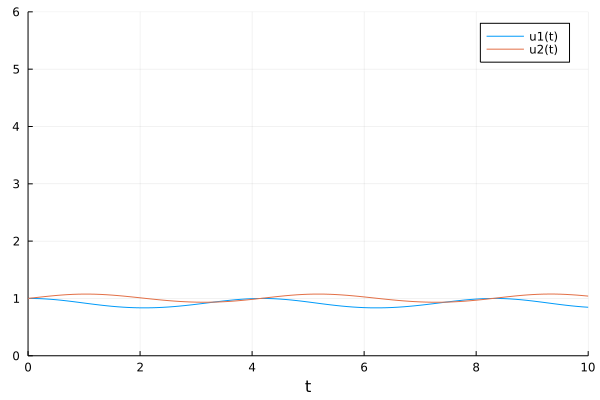

0.9204485638898424

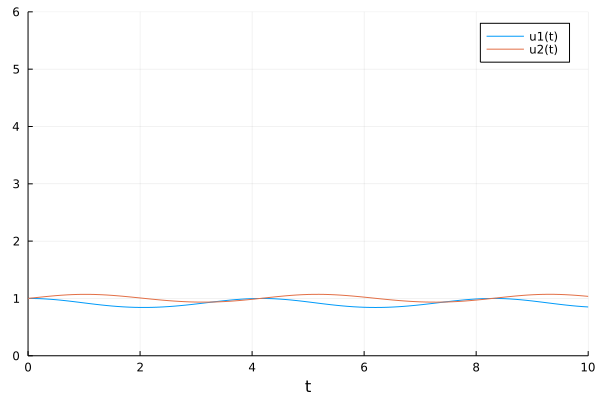

0.8458304075703594

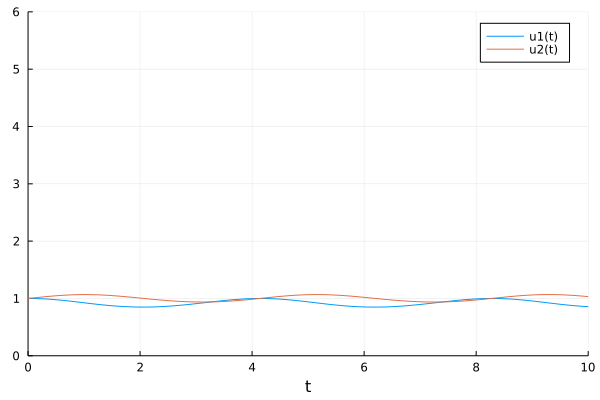

0.775758945918737

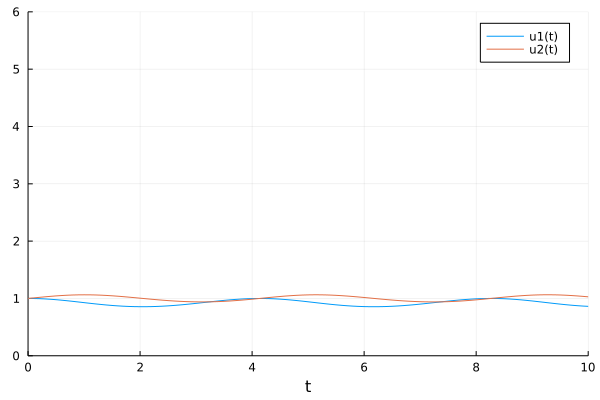

0.709972107769935

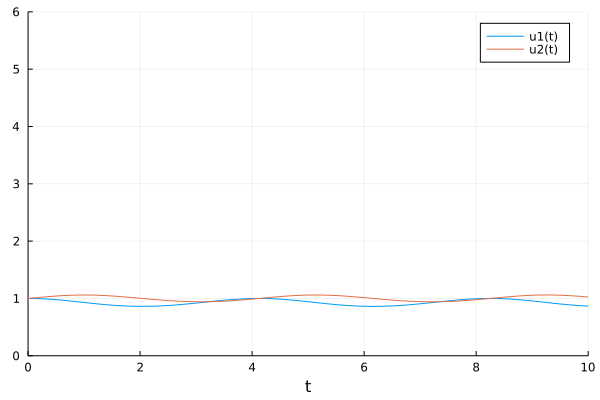

0.6483364160088436

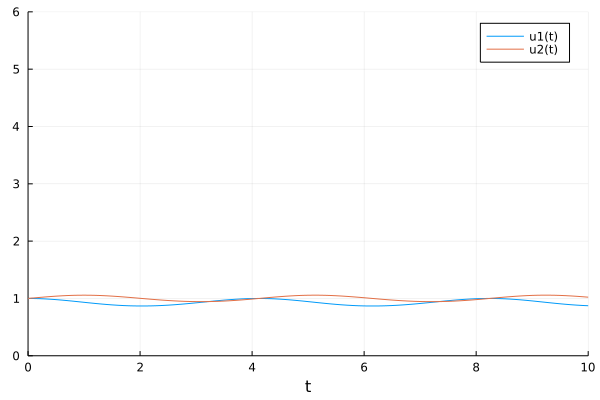

0.5906391747032088

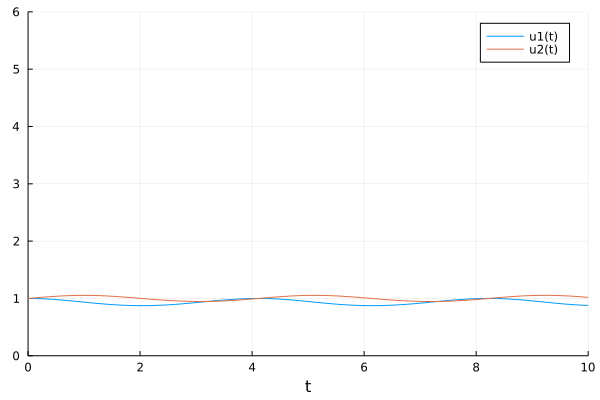

0.5366833298853533

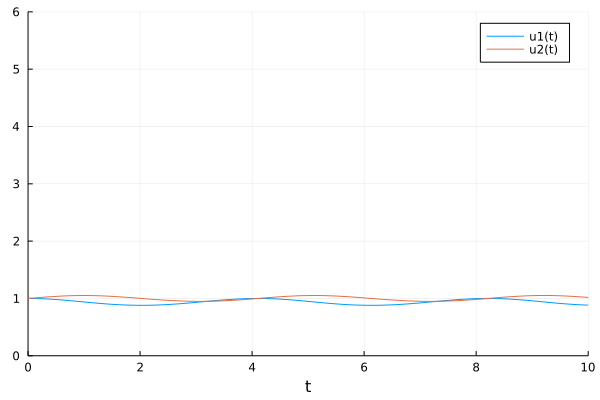

0.4863138260723308

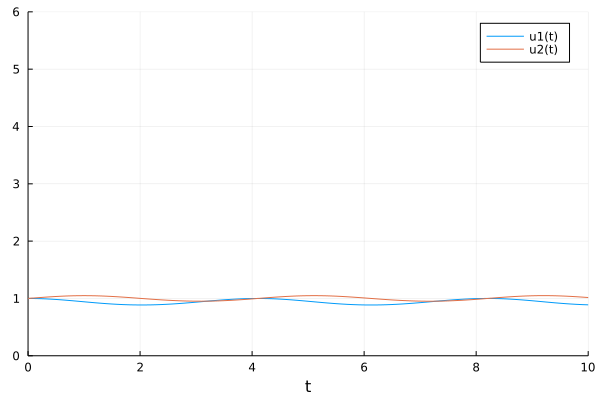

0.43940127514894733

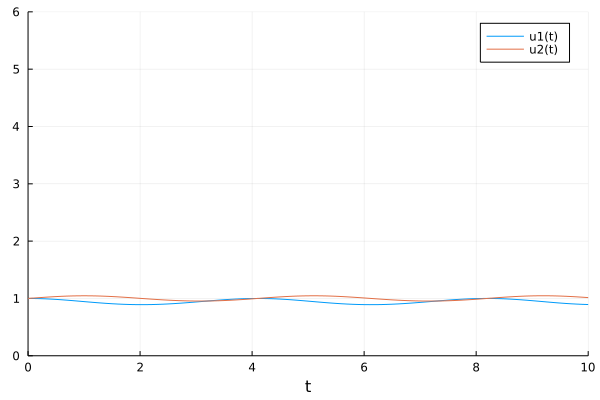

0.395835247505578

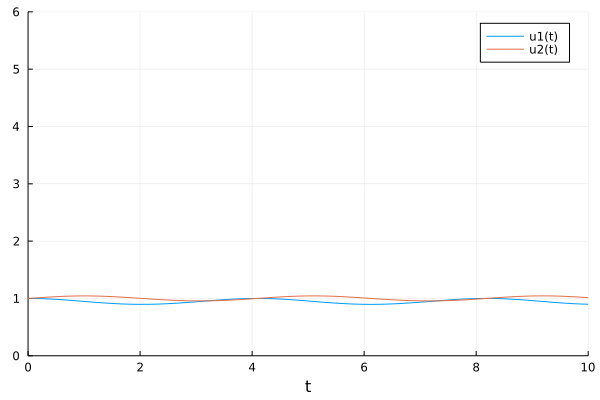

0.35551913793947376

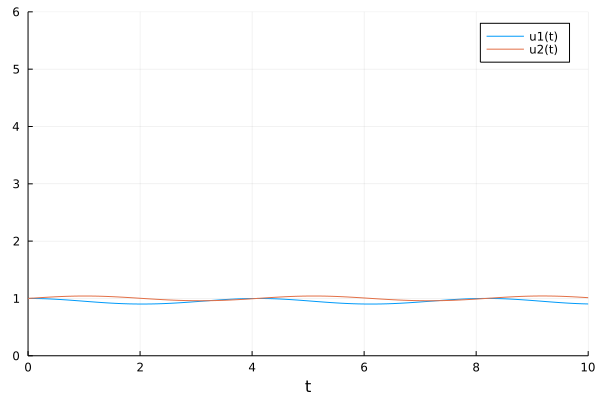

0.3183509529049491

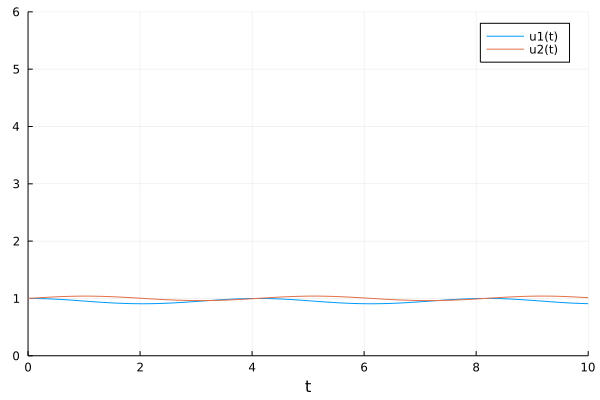

0.28422618765800195

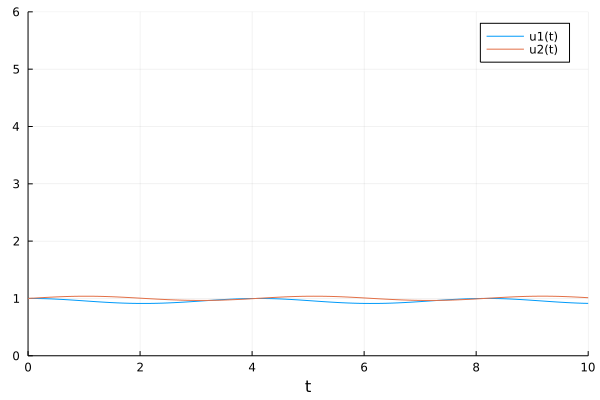

In [12]:
data = Iterators.repeated((), 100)
opt = ADAM(0.1)
cb = function () #callback function to observe training
  display(loss_rd())
  # using `remake` to re-create our `prob` with current parameters `p`
  display(plot(solve(remake(prob,p=p),Tsit5(),saveat=0.1),ylim=(0,6)))
end

# Display the ODE with the initial parameter values.
cb()

Flux.train!(loss_rd, params, data, opt, cb = cb)

In [13]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)

Chain(
  Dense(784, 32, relu),                 # 25_120 parameters
  Dense(32, 10),                        # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

In [14]:
m = Chain(
  Dense(28^2, 32, relu),
  # this would require an ODE of 32 parameters
  p -> solve(prob,Tsit5(),p=p,saveat=0.1)[1,:],
  Dense(32, 10),
  softmax)

Chain(
  Dense(784, 32, relu),                 # 25_120 parameters
  var"#5#6"(),
  Dense(32, 10),                        # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

In [15]:
m = Chain(
  Conv((2,2), 1=>16, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 16=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  x -> solve(prob,Tsit5(),u0=x,saveat=0.1)[1,:],
  Dense(288, 10), softmax) |> gpu

Chain(
  Conv((2, 2), 1 => 16, relu),          # 80 parameters
  var"#7#11"(),
  Conv((2, 2), 16 => 8, relu),          # 520 parameters
  var"#8#12"(),
  var"#9#13"(),
  var"#10#14"(),
  Dense(288, 10),                       # 2_890 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 3_490 parameters, 14.461 KiB.

In [16]:
rober = @ode_def Rober begin
  dy₁ = -k₁*y₁+k₃*y₂*y₃
  dy₂ =  k₁*y₁-k₂*y₂^2-k₃*y₂*y₃
  dy₃ =  k₂*y₂^2
end k₁ k₂ k₃
prob = ODEProblem(rober,[1.0;0.0;0.0],(0.0,1e11),(0.04,3e7,1e4))
solve(prob,CVODE_Adams())

LoadError: UndefVarError: CVODE_Adams not defined

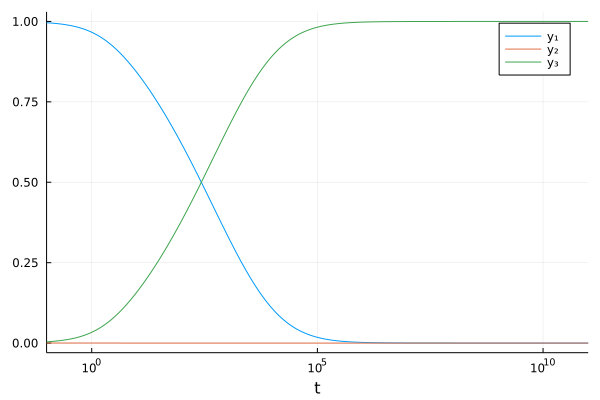

In [17]:
sol = solve(prob,KenCarp4())
using Plots
plot(sol,xscale=:log10,tspan=(0.1,1e11))